In [28]:
%pip install numpy matplotlib scipy pandas seaborn scikit-learn tensorflow sklearn tensorflow_datasets 

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


ERROR: Could not find a version that satisfies the requirement sklearn (from versions: none)
ERROR: No matching distribution found for sklearn
Note: you may need to restart the kernel to use updated packages.


In [32]:
## Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow_datasets as tfds
import tensorflow as tf
from sklearn.metrics import accuracy_score
from tensorflow.keras import utils
# import tensorflow_text as tf_text

In [33]:
## Utility functions
def plot_graphs(history, metric):
    plt.plot(history.history[metric])
    plt.plot(history.history['val_'+metric], '')
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend([metric, 'val_'+metric])

In [34]:
# Read data
path_ds = r"/kaggle/input/final-dataset/final_dataset_v1_afternb1.csv"
df_ds = pd.read_csv(path_ds)

# First, split into train and test sets (80% train, 20% test)
train_essays, test_essays = train_test_split(df_ds, test_size=0.2, random_state=42)

# Then, split the train set into train and validation sets (67% train, 33% validation)
train_essays, val_essays = train_test_split(train_essays, test_size=0.33, random_state=42)

# Check the size of each set
print(f'Training set size: {len(train_essays)}')
print(f'Validation set size: {len(val_essays)}')
print(f'Test set size: {len(test_essays)}')

# Show first few rows of the train set
train_essays.head()

Training set size: 38084
Validation set size: 18759
Test set size: 14211


,text,label,source,word_length,text_no_sw
39759,self-reliance is a concept that has become inc...,1,mistral7binstruct_v1,376,self-reliance concept become increasingly impo...
35109,marijuana is a drug that can be made from a pl...,1,falcon_180b_v1,269,marijuana drug made plant called cannabis . us...
24262,"today, the majority of humans own and operate ...",0,persuade_corpus,542,"today , majority humans operate cell phones da..."
60113,it is century people have their own opinion a...,0,personal-sunilthite,439,century people opinion decisions . human revo...
7659,"with the information the article ""making mona ...",0,persuade_corpus,656,information article `` making mona lisa smile ...


In [35]:
## Create dataset
# Create TensorFlow datasets from the DataFrames
batch_size = 16

train_dataset = tf.data.Dataset.from_tensor_slices(
    (train_essays['text'].values, train_essays['label'].values)
).batch(batch_size)

val_dataset = tf.data.Dataset.from_tensor_slices(
    (val_essays['text'].values, val_essays['label'].values)
).batch(batch_size)

test_dataset = tf.data.Dataset.from_tensor_slices(
    (test_essays['text'].values)
).batch(batch_size)

In [36]:
for text_batch, label_batch in train_dataset.take(1):
    for i in range(1):
        print("Question: ", text_batch.numpy()[i])
        print("Label:", label_batch.numpy()[i])

Question:  b'self-reliance is a concept that has become increasingly important in recent years, particularly in light of current events and decision-making. it refers to the ability of individuals, businesses, and communities to rely on their own resources and capabilities to achieve their goals, rather than relying on external support or assistance.self-reliance has a significant impact on individuals, as it allows them to take control of their own lives and make decisions based on their own values and priorities. it also promotes personal growth and development, as individuals learn to identify their strengths and weaknesses and work to improve themselves.in the business world, self-reliance is essential for success. companies that are self-reliant are able to adapt to changing market conditions and make decisions based on their own resources, rather than relying on external factors that they have no control over. this allows them to be more agile and responsive to the needs of their

In [37]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64
VOCAB_SIZE = 1000

encoder = tf.keras.layers.TextVectorization(max_tokens=VOCAB_SIZE)
encoder.adapt(train_dataset.map(lambda text, label: text))

In [38]:
vocab = np.array(encoder.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'the', 'to', 'and', 'a', 'of', 'in', 'that', 'is',
       'it', 'for', 'you', 'be', 'can', 'they', 'are', 'have', 'on',
       'not'], dtype='<U15')

In [39]:
# Define the model
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        mask_zero=True),  # Use masking to handle variable sequence lengths
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

# Compile the model, including AUC as a metric
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy', tf.keras.metrics.AUC(name='auc')])  # Add AUC metric

# Train the model
history = model.fit(train_dataset, epochs=20,  # Change to 20 epochs
                    validation_data=val_dataset,
                    validation_steps=30)

Epoch 1/20
2381/2381 ━━━━━━━━━━━━━━━━━━━━ 86s 35ms/step - accuracy: 0.8097 - auc: 0.8037 - loss: 0.3575 - val_accuracy: 0.9792 - val_auc: 0.9827 - val_loss: 0.0615
Epoch 2/20
2381/2381 ━━━━━━━━━━━━━━━━━━━━ 82s 34ms/step - accuracy: 0.9750 - auc: 0.9760 - loss: 0.0855 - val_accuracy: 0.9792 - val_auc: 0.9792 - val_loss: 0.0869
Epoch 3/20
2381/2381 ━━━━━━━━━━━━━━━━━━━━ 81s 34ms/step - accuracy: 0.9829 - auc: 0.9840 - loss: 0.0584 - val_accuracy: 0.9937 - val_auc: 0.9981 - val_loss: 0.0296
Epoch 4/20
2381/2381 ━━━━━━━━━━━━━━━━━━━━ 81s 34ms/step - accuracy: 0.9855 - auc: 0.9864 - loss: 0.0509 - val_accuracy: 0.9896 - val_auc: 0.9891 - val_loss: 0.0500
Epoch 5/20
2381/2381 ━━━━━━━━━━━━━━━━━━━━ 81s 34ms/step - accuracy: 0.9857 - auc: 0.9869 - loss: 0.0496 - val_accuracy: 0.9792 - val_auc: 0.9787 - val_loss: 0.0528
Epoch 6/20
2381/2381 ━━━━━━━━━━━━━━━━━━━━ 81s 34ms/step - accuracy: 0.9863 - auc: 0.9879 - loss: 0.0456 - val_accuracy: 0.9646 - val_auc: 0.9842 - val_loss: 0.0851
Epoch 7/20
2381/

(0.0, 0.22357869613915682)

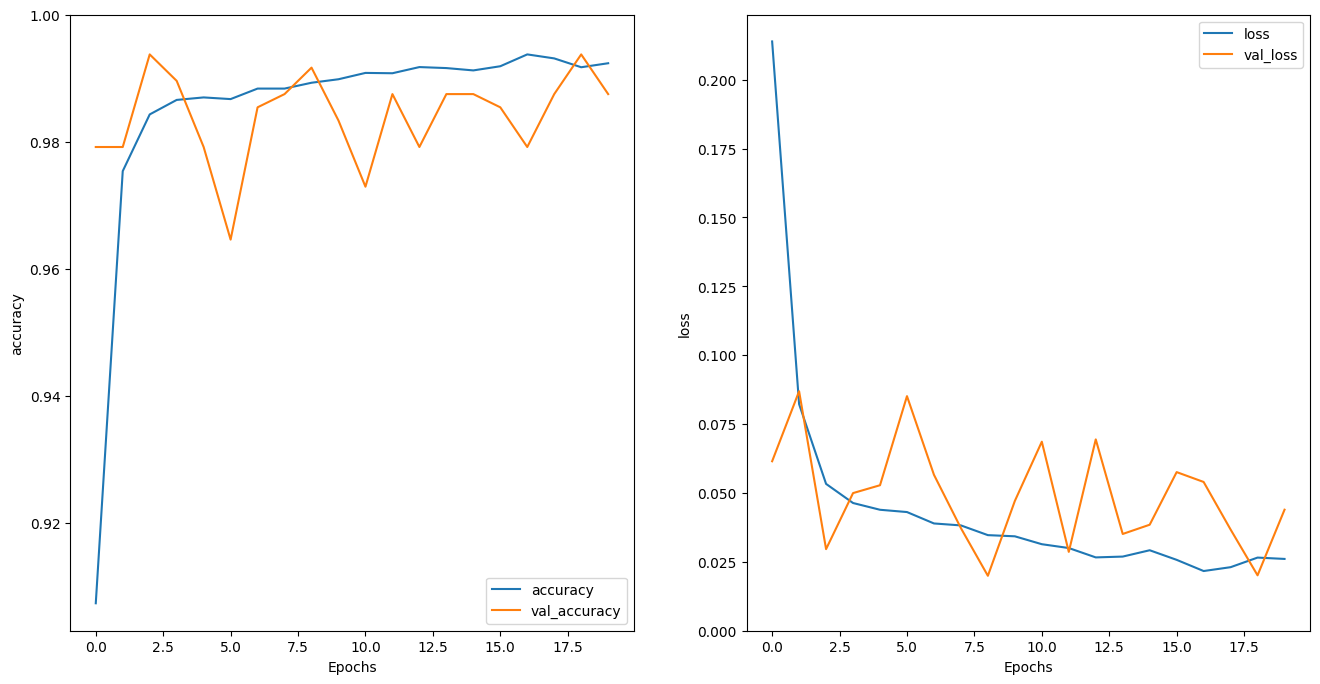

In [40]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)

In [41]:
# Predict on the test set
predictions = model.predict(test_dataset)

# Convert predictions from logits to binary labels (0 or 1)
predicted_labels = [1 if pred >= 0.5 else 0 for pred in predictions]

# Create a submission DataFrame
sub = pd.DataFrame()
sub['text'] = test_essays['text']  # Using 'text' column instead of 'id'
sub['predicted'] = predicted_labels  # Store predicted labels
sub['actual'] = test_essays['label']  # Store actual labels for comparison

# Calculate accuracy
accuracy = accuracy_score(test_essays['label'], predicted_labels)
print(f'Test Accuracy: {accuracy * 100:.2f}%')

# Save predictions to CSV in the output directory (specific to Kaggle)
sub.to_csv('/kaggle/working/submission.csv', index=False)

# Show first few rows of the submission
sub.head()

889/889 ━━━━━━━━━━━━━━━━━━━━ 14s 16ms/step
Test Accuracy: 98.84%


,text,predicted,actual
21723,"leonardo da vinci's renaissance painting ""mona...",0,0
46378,"phones have come a very long way since , phone...",0,0
63506,there are a few things to unpack in this promp...,1,1
18048,have you ever through of somethig simple in li...,0,0
25250,different places from all over the world have ...,0,0
